# Analysis of results

This notebooks deals with analyzing the human evaluation part. 
1) We compute the agreement among the evaluators (humans + GPT4) on their opinions about the systems' outputs.
2) We plot and group statistics about votes.

In [103]:
#import utils
import pandas as pd
import spacy
#from utils import *
import kendall_w as kw # rank agreement
import itertools
from scipy.stats import spearmanr, pearsonr, weightedtau, kendalltau
from sklearn.metrics import cohen_kappa_score
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
%matplotlib inline
import matplotlib as mpl

TODO

Make function that given a group, computes the relevant agreements tables and maybe also other metrics

In [104]:
def get_df_all_annotators():
    """Goes into the folder annotation/human and /annotation/gpt and gets the answers into a single combined df"""
    result = []
    result += combine_answer_csvs('../../evaluation/annotation/human/')
    result += combine_answer_csvs('../../evaluation/annotation/gpt/')
    return pd.concat(result, ignore_index=True)

def combine_answer_csvs(directory_path):
    # Pattern to match files starting with 'answer' and ending with '.csv'
    pattern = f"{directory_path}/answer*.csv"
    
    # Use glob to find all files matching the pattern
    files = glob.glob(pattern)
    
    # List to hold dataframes
    dfs = []
    
    # Loop over the list of file names
    for file in files:
        # Read the CSV file and append it to the list of dataframes
        df = pd.read_csv(file)
        dfs.append(df)
    
    return dfs

In [105]:
#df_targets = pd.read_csv("/data/enrico_benedetti/nihongoexample/data/targets/target_words.csv")
#df_gpt4 = pd.read_csv("/data/enrico_benedetti/nihongoexample/evaluation/annotation/gpt/answers_gpt4.csv")
#df_gpt4_m = pd.read_csv("/data/enrico_benedetti/nihongoexample/evaluation/annotation/gpt/answers_gpt4_multiple.csv")
#combined_df = pd.read_csv("/data/enrico_benedetti/nihongoexample/data/targets/combined_human_eval")

df_targets = pd.read_csv("../../data/targets/target_words.csv")
df_gpt4 = pd.read_csv("../../evaluation/annotation/gpt/answers_gpt4.csv")
df_gpt4_m = pd.read_csv("../../evaluation/annotation/gpt/answers_gpt4_multiple.csv")
combined_df = pd.read_csv("../../data/targets/combined_human_eval") # this is to get the sys ids back into original order

df = get_df_all_annotators()

# the df with every annotator etc

level_map = {'N1': 1.0, 'N2': 0.75, 'N3': 0.5, 'N4': 0.25, 'N5': 0.0, np.nan: -1.0}
system_name_map = {1: "Retrieval", 2: "LLM-jp", 3: "GPT-3.5 Turbo"}

meta_info = ['target_word', 'target_level', 'context_sentence', 'block_id']
all_levels = ['N1', 'N2', 'N3', 'N4', 'N5']
eval_levels = ['N1', 'N3', 'N5']

#level_maps for pingouin - also 'rejected' is a possible value. we ignore it / vs set it as -1?
level_map_pg = {'N1':1.0, 'N2': 0.75, 'N3': 0.5, 'N4':0.25, 'N5': 0.0, 'rejected': np.nan, np.nan: np.nan}
sense_map_pg = {'Similar': 1.0, 'Not similar': 0.0, 'rejected': np.nan, np.nan: np.nan}
similarity_map_pg = {'High':1.0, 'Medium': 0.5, 'Low': 0, np.nan: np.nan}
ranking_map_pg = {'1st': 1.0, '2nd': 0.5, '3rd': 0, np.nan: np.nan}
reject_map_pg = {True :1.0, False: 0, np.nan: np.nan}


# # scale slightly modified
# level_map_pg = {'N1':1.0, 'N2': 0.75, 'N3': 0.5, 'N4':0.25, 'N5': 0.0, 'rejected': np.nan, np.nan: np.nan}
# sense_map_pg = {'Similar': 1.0, 'Not similar': 0.0, 'rejected': np.nan, np.nan: np.nan}
# similarity_map_pg = {'High':1.0, 'Medium': 0.7, 'Low': 0.0, np.nan: np.nan}
# ranking_map_pg = {'1st': 1.0, '2nd': 0.7, '3rd': 0.0, np.nan: np.nan}
# reject_map_pg = {True: 1.0, False: 0.0, np.nan: np.nan}

# level_map_pg = {'N1':1.0, 'N2': 0.75, 'N3': 0.5, 'N4':0.25, 'N5': 0.0, 'rejected': np.nan, np.nan: np.nan}
# sense_map_pg = {'Similar': 1.0, 'Not similar': 0.0, 'rejected': np.nan, np.nan: np.nan}
# similarity_map_pg = {'High':10.0, 'Medium': 7.0, 'Low': 0.0, np.nan: np.nan}
# ranking_map_pg = {'1st': 10.0, '2nd': 7.0, '3rd': 0.0, np.nan: np.nan}
# reject_map_pg = {True: 1.0, False: 0.0, np.nan: np.nan}

In [106]:
#df[df['ann_id'].str.startswith('gpt')]['sense_human'].value_counts() # to check if its well done now

In [107]:
def get_df_restore_ordering(first_df, combined_df):
    """Reapplies the original system ids to df, given the df with random ordering. Assumes the sheet is the one used in the human evaluation."""
    # need to reorder and get the original systems
    ordering_map = {1: 'A', 2: 'E', 3: 'I'}
    first_df['random_ordering'] = first_df['sys_id'].apply(lambda id: ordering_map[id])
    result = combined_df[['sentence', 'random_ordering', 'target_word', 'target_level', 'context_sentence', 'block_id', 'system_id']]
    # to maintain the ordering - merge left
    result = first_df.merge(combined_df, how='left', validate='many_to_many')
    result['sys_id'] = result['system_id']
    result = result.drop(columns=['system_id'])
    return result

def set_rejected_to_nan(df):
    df = df.copy()
    """If a sentence is rejected, it sets level and sense ratings to nan."""
    for id, data in df.iterrows():
        # check that if it is rejected, then scores for sense and difficulty are nan
        if data['reject'] == True:
            df.loc[id, ['level_human']] = np.nan
            df.loc[id, ['sense_human']] = np.nan
    return df


def mark_p_value(cell):
    try:
        p_value = cell[1]
        if p_value < 0.05:
             return (f"{cell[0]:.2f}$^*$")
        return f"{cell[0]:.2f}"
    except:
        return cell

def compute_ICC(data_grouped, item, rater_col, map_pg: dict):
    """Given a grouped dataframe (with ratings as lists), computes the Intra Class Correlation Coefficient using the rater_col as raters, and the ratings as subjects.
    Pass a mapping function from categorical to numerical values."""

    k=5
    if item in ['rank_human', 'diversity_human']:
        data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])

    # make dictionary in the expected format (list of ratings for each rater)
    dct = {f'{data[rater_col]}': data[item] for id, data in data_grouped.iterrows()}
    # make df in the expected format
    # in case it is rank or syntax diversity, we need to take only one out of k elements.
    df = pd.DataFrame(dct)
    df['index'] = df.index

    # transform None in NaNs
    def _sub_map(x):
        if x != None:
            return map_pg[x]
        else: return np.nan

    df = pd.melt(df, id_vars=['index'], value_vars=list(df)[:-1])
    # convert to numeric
    df['value_numeric'] = df['value'].apply(_sub_map)
    results = pg.intraclass_corr(df, 'index', 'variable', 'value_numeric', nan_policy='omit')
    print(f"ICC for {item} ratings")
    # more info: amount of nans (those that are not considered)
    #print(f"count of nan values (excluded from the calculation): {df['value'].isna().value_counts()}")
    # the excluded amount is the intersection of nan values
    nan_mask = df['value_numeric'].isna()
    total_lines = df['index'].unique().shape[0]
    lines_ignored = df[nan_mask]['index'].unique().shape[0]
    print(f"ignored responses: {lines_ignored}/{total_lines}. sample is: {total_lines-lines_ignored}/{total_lines}")
    return results

In [108]:
#sense_map_pg_nan = {'Similar': 1.0, 'Not similar': 0.0, np.nan: -1}
#compute_ICC(group_humans, 'sense_human', 'ann_id', sense_map_pg)

In [109]:
df_gpt4_m['sys_id'].value_counts()

sys_id
1    450
2    450
3    450
Name: count, dtype: int64

In [110]:
df_gpt4_m = get_df_restore_ordering(df_gpt4_m, combined_df)
df_gpt4_m = set_rejected_to_nan(df_gpt4_m)

df_gpt4 = get_df_restore_ordering(df_gpt4, combined_df)
df_gpt4 = set_rejected_to_nan(df_gpt4)

df = get_df_restore_ordering(df, combined_df)
#df = set_rejected_to_nan(df) # not needed anymore because logic is set before when reading.

In [111]:
group_m = df_gpt4_m.groupby(by=['ann_id'], as_index=False, dropna=False).agg(list)
numerical_scores_level = group_m['level_human'].apply(lambda l: [level_map[element] for element in l])

In [112]:
df_gpt4_m.value_counts(subset=['level_human'])

level_human
N3             373
N5             285
N4             284
N2             241
N1             115
Name: count, dtype: int64

In [113]:
pearsonr(x=numerical_scores_level[1], y=numerical_scores_level[2])

PearsonRResult(statistic=0.9247393570322182, pvalue=4.575122022123105e-190)

In [114]:
spearmanr(a=numerical_scores_level[1], b=numerical_scores_level[2], nan_policy='omit')

SignificanceResult(statistic=0.9566465277191526, pvalue=3.86670283109107e-242)

In [115]:
# level_map_cohen = {'N1':'N1', 'N2': 'N2', 'N3': 'N3', 'N4':'N4', 'N5':'N5', np.nan: ''}
# categorical_scores_level = group_m['level_human'].apply(lambda l: [level_map_cohen[element] for element in l])
# cohen_kappa_score(y1=categorical_scores_level[0], y2=categorical_scores_level[1])

In [116]:
group_m

,ann_id,target_word,context_sentence,target_level,block_id,sys_id,diversity_human,rank_human,sentence,level_human,...,sense_score,quality_score,sentence_docs,parse_tree,tokenized,syntax_div_score,lexical_div_score,div_score,total_score,split
0,gpt4_1,"[相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相...","[また、東西お互いに相手を非難するプロパガンダ放送を流し合っていた。, また、東西お互いに相...","[N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[Medium, Medium, Medium, Medium, Medium, High,...","[1st, 1st, 1st, 1st, 1st, 2nd, 2nd, 2nd, 2nd, ...",[東京と大阪はライバル同士であるため、それぞれの地域では互いに相手を非難するプロパガンダ放送...,"[N2, N2, N3, N2, N3, N1, N1, N2, N1, N1, N3, N...",...,"[nan, nan, nan, nan, nan, 0.72510344, 0.728948...","[nan, nan, nan, nan, nan, 0.8625517189502716, ...","[nan, nan, nan, nan, nan, 外交経験が無い素人2人組の外交は半年が空...","[nan, nan, nan, nan, nan, (ADJ_ROOT (NOUN_nsub...","[nan, nan, nan, nan, nan, ['外交', '経験', 'が', '無...","[nan, nan, nan, nan, nan, 1.0, 1.0, 0.94619137...","[nan, nan, nan, nan, nan, 0.9397916666666668, ...","[nan, nan, nan, nan, nan, 0.9698958333333334, ...","[nan, nan, nan, nan, nan, 0.9162237761418024, ...","[test, test, test, test, test, test, test, tes..."
1,gpt4_2,"[相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相...","[また、東西お互いに相手を非難するプロパガンダ放送を流し合っていた。, また、東西お互いに相...","[N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[Medium, Medium, Medium, Medium, Medium, High,...","[2nd, 2nd, 2nd, 2nd, 2nd, 1st, 1st, 1st, 1st, ...",[東京と大阪はライバル同士であるため、それぞれの地域では互いに相手を非難するプロパガンダ放送...,"[N2, N2, N3, N2, N3, N1, N1, N1, N1, N1, N2, N...",...,"[nan, nan, nan, nan, nan, 0.72510344, 0.728948...","[nan, nan, nan, nan, nan, 0.8625517189502716, ...","[nan, nan, nan, nan, nan, 外交経験が無い素人2人組の外交は半年が空...","[nan, nan, nan, nan, nan, (ADJ_ROOT (NOUN_nsub...","[nan, nan, nan, nan, nan, ['外交', '経験', 'が', '無...","[nan, nan, nan, nan, nan, 1.0, 1.0, 0.94619137...","[nan, nan, nan, nan, nan, 0.9397916666666668, ...","[nan, nan, nan, nan, nan, 0.9698958333333334, ...","[nan, nan, nan, nan, nan, 0.9162237761418024, ...","[test, test, test, test, test, test, test, tes..."
2,gpt4_3,"[相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相...","[また、東西お互いに相手を非難するプロパガンダ放送を流し合っていた。, また、東西お互いに相...","[N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[Medium, Medium, Medium, Medium, Medium, High,...","[1st, 1st, 1st, 1st, 1st, 2nd, 2nd, 2nd, 2nd, ...",[東京と大阪はライバル同士であるため、それぞれの地域では互いに相手を非難するプロパガンダ放送...,"[N2, N2, N4, N2, N4, N1, N1, N1, N1, N1, N3, N...",...,"[nan, nan, nan, nan, nan, 0.72510344, 0.728948...","[nan, nan, nan, nan, nan, 0.8625517189502716, ...","[nan, nan, nan, nan, nan, 外交経験が無い素人2人組の外交は半年が空...","[nan, nan, nan, nan, nan, (ADJ_ROOT (NOUN_nsub...","[nan, nan, nan, nan, nan, ['外交', '経験', 'が', '無...","[nan, nan, nan, nan, nan, 1.0, 1.0, 0.94619137...","[nan, nan, nan, nan, nan, 0.9397916666666668, ...","[nan, nan, nan, nan, nan, 0.9698958333333334, ...","[nan, nan, nan, nan, nan, 0.9162237761418024, ...","[test, test, test, test, test, test, test, tes..."


In [117]:
#level_map_pg = {'N1':1.0, 'N2': 0.9, 'N3': 0.7, 'N4':0.25, 'N5':0.0, np.nan: np.nan} # does not change much
compute_ICC(group_m, 'level_human', 'ann_id', map_pg=level_map_pg)

ICC for level_human ratings
ignored responses: 20/450. sample is: 430/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.940667,48.562046,429,860,0.0,"[0.93, 0.95]"
1,ICC2,Single random raters,0.940666,48.506936,429,858,0.0,"[0.93, 0.95]"
2,ICC3,Single fixed raters,0.940602,48.506936,429,858,0.0,"[0.93, 0.95]"
3,ICC1k,Average raters absolute,0.979408,48.562046,429,860,0.0,"[0.98, 0.98]"
4,ICC2k,Average random raters,0.979407,48.506936,429,858,0.0,"[0.98, 0.98]"
5,ICC3k,Average fixed raters,0.979384,48.506936,429,858,0.0,"[0.98, 0.98]"


In [118]:
# for looking also at sublevels - there is more agreement in n1 and less in n5
# group_m = df_gpt4_m.groupby(by=['ann_id', 'target_level'], as_index=False, dropna=False).agg(list)
# mask_level = group_m['target_level'] == 'N5'
# compute_ICC(group_m[mask_level], 'level_human', 'ann_id', map_pg=level_map_pg)

In [119]:

compute_ICC(group_m, 'sense_human', 'ann_id', map_pg=sense_map_pg)

ICC for sense_human ratings
ignored responses: 20/450. sample is: 430/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.640155,6.336916,429,860,2.728919e-116,"[0.59, 0.68]"
1,ICC2,Single random raters,0.640089,6.327357,429,858,6.061785e-116,"[0.59, 0.68]"
2,ICC3,Single fixed raters,0.639742,6.327357,429,858,6.061785e-116,"[0.59, 0.68]"
3,ICC1k,Average raters absolute,0.842195,6.336916,429,860,2.728919e-116,"[0.81, 0.87]"
4,ICC2k,Average random raters,0.842157,6.327357,429,858,6.061785e-116,"[0.81, 0.87]"
5,ICC3k,Average fixed raters,0.841956,6.327357,429,858,6.061785e-116,"[0.81, 0.87]"


In [120]:
compute_ICC(group_m, 'reject', 'ann_id', map_pg=reject_map_pg)

ICC for reject ratings
ignored responses: 0/450. sample is: 450/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.860274,19.47057,449,900,2.689566e-289,"[0.84, 0.88]"
1,ICC2,Single random raters,0.860348,19.69617,449,898,9.470668e-291,"[0.84, 0.88]"
2,ICC3,Single fixed raters,0.861727,19.69617,449,898,9.470668e-291,"[0.84, 0.88]"
3,ICC1k,Average raters absolute,0.948640,19.47057,449,900,2.689566e-289,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.948671,19.69617,449,898,9.470668e-291,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.949229,19.69617,449,898,9.470668e-291,"[0.94, 0.96]"


#### Dealing with the system outputs together

Here we get the instance of a single measurement by grouping

In [121]:
group_div = df_gpt4_m.groupby(by=['ann_id','block_id', 'sys_id'], as_index=False, dropna=False).agg('first')
# then regroup by list
group_div = group_div.groupby(by=['ann_id'], as_index=False, dropna=False).agg(list)
#group_div[meta_info + ['diversity_human', 'sys_id']]

In [122]:
# humans test (maybe bc of blanks?)
group_div = df.groupby(by=['ann_id','block_id', 'sys_id'], as_index=False, dropna=False).agg('first')
group_div = group_div.groupby(by=['ann_id'], as_index=False, dropna=False).agg(list)

# delete
#compute_ICC(group_div, 'diversity_human', 'ann_id', map_pg=similarity_map_pg)
#compute_ICC(group_div, 'rank_human', 'ann_id', map_pg=ranking_map_pg)

In [123]:
# we should measure the inter - class correlation also?

### Multiple annotators etc
Here we try to find what's the consistency among all annotators

In [124]:
# debug
df['reject'].value_counts()
df['level_human'].value_counts()

level_human
N3          1121
N4           648
N5           613
N2           581
N1           347
rejected     305
Name: count, dtype: int64

In [125]:
group = df.groupby(by=['ann_id'], as_index=False, dropna=False).agg(list)

In [126]:
group_humans = group[group['ann_id'].str.startswith('human_native')]
group_humans

,ann_id,target_word,context_sentence,target_level,block_id,sys_id,diversity_human,rank_human,sentence,level_human,...,sense_score,quality_score,sentence_docs,parse_tree,tokenized,syntax_div_score,lexical_div_score,div_score,total_score,split
6,human_native_1,"[相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相...","[また、東西お互いに相手を非難するプロパガンダ放送を流し合っていた。, また、東西お互いに相...","[N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[Medium, Medium, Medium, Medium, Medium, High,...","[3rd, 3rd, 3rd, 3rd, 3rd, 1st, 1st, 1st, 1st, ...",[東京と大阪はライバル同士であるため、それぞれの地域では互いに相手を非難するプロパガンダ放送...,"[N2, N2, rejected, N2, N4, N1, N1, N2, N1, N1,...",...,"[nan, nan, nan, nan, nan, 0.72510344, 0.728948...","[nan, nan, nan, nan, nan, 0.8625517189502716, ...","[nan, nan, nan, nan, nan, 外交経験が無い素人2人組の外交は半年が空...","[nan, nan, nan, nan, nan, (ADJ_ROOT (NOUN_nsub...","[nan, nan, nan, nan, nan, ['外交', '経験', 'が', '無...","[nan, nan, nan, nan, nan, 1.0, 1.0, 0.94619137...","[nan, nan, nan, nan, nan, 0.9397916666666668, ...","[nan, nan, nan, nan, nan, 0.9698958333333334, ...","[nan, nan, nan, nan, nan, 0.9162237761418024, ...","[test, test, test, test, test, test, test, tes..."
7,human_native_2,"[相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相...","[また、東西お互いに相手を非難するプロパガンダ放送を流し合っていた。, また、東西お互いに相...","[N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[Low, Low, Low, Low, Low, Low, Low, Low, Low, ...","[1st, 1st, 1st, 1st, 1st, 3rd, 3rd, 3rd, 3rd, ...",[東京と大阪はライバル同士であるため、それぞれの地域では互いに相手を非難するプロパガンダ放送...,"[N2, N2, N3, N2, N3, N1, rejected, N2, rejecte...",...,"[nan, nan, nan, nan, nan, 0.72510344, 0.728948...","[nan, nan, nan, nan, nan, 0.8625517189502716, ...","[nan, nan, nan, nan, nan, 外交経験が無い素人2人組の外交は半年が空...","[nan, nan, nan, nan, nan, (ADJ_ROOT (NOUN_nsub...","[nan, nan, nan, nan, nan, ['外交', '経験', 'が', '無...","[nan, nan, nan, nan, nan, 1.0, 1.0, 0.94619137...","[nan, nan, nan, nan, nan, 0.9397916666666668, ...","[nan, nan, nan, nan, nan, 0.9698958333333334, ...","[nan, nan, nan, nan, nan, 0.9162237761418024, ...","[test, test, test, test, test, test, test, tes..."
8,human_native_3,"[相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相手, 相...","[また、東西お互いに相手を非難するプロパガンダ放送を流し合っていた。, また、東西お互いに相...","[N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N1, N...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, ...","[Medium, Medium, Medium, Medium, Medium, High,...","[3rd, 3rd, 3rd, 3rd, 3rd, 1st, 1st, 1st, 1st, ...",[東京と大阪はライバル同士であるため、それぞれの地域では互いに相手を非難するプロパガンダ放送...,"[N2, N2, N2, N2, N3, N1, rejected, N2, N1, N1,...",...,"[nan, nan, nan, nan, nan, 0.72510344, 0.728948...","[nan, nan, nan, nan, nan, 0.8625517189502716, ...","[nan, nan, nan, nan, nan, 外交経験が無い素人2人組の外交は半年が空...","[nan, nan, nan, nan, nan, (ADJ_ROOT (NOUN_nsub...","[nan, nan, nan, nan, nan, ['外交', '経験', 'が', '無...","[nan, nan, nan, nan, nan, 1.0, 1.0, 0.94619137...","[nan, nan, nan, nan, nan, 0.9397916666666668, ...","[nan, nan, nan, nan, nan, 0.9698958333333334, ...","[nan, nan, nan, nan, nan, 0.9162237761418024, ...","[test, test, test, test, test, test, test, tes..."


In [127]:
# function that given a group and a list of rater names, computes basically every ICC
def compute_ICC_all(df, annotators_to_consider):
    """Computes consistency agreements among annotators. annotators_to_consider can be a list of annotators_id (str) or just one string, in that case it will be used to select all annotators whose ann_id start with it.
    Output format is a dictionary containing the table for the specific variable."""

    print(f"computing ICC for {annotators_to_consider}...")

    results = {}

    # reduce group, considering only those annotators
    if isinstance(annotators_to_consider, str):
        df = df[df['ann_id'].str.startswith(annotators_to_consider)]
    elif isinstance(annotators_to_consider, list):
        df = df[df['ann_id'].isin(annotators_to_consider)]
    group = df.groupby(by=['ann_id'], as_index=False, dropna=False).agg(list)

    display(group['ann_id'])

    # LEVEL
    results["level_human"] = compute_ICC(group, 'level_human', 'ann_id', map_pg=level_map_pg)
    display(results["level_human"])

    # SENSE

    results["sense_human"] = compute_ICC(group, 'sense_human', 'ann_id', map_pg=sense_map_pg)
    display(results['sense_human'])

    # REJECT

    results["reject"] = compute_ICC(group, 'reject', 'ann_id', map_pg=reject_map_pg)
    display(results["reject"])

    # for the grouped ones, take first from easy system in each block - no need anymore
    #group_list = df.groupby(by=['ann_id','block_id', 'sys_id'], as_index=False, dropna=False).agg('first')
    # then regroup by list
    #group_list = group_list.groupby(by=['ann_id'], as_index=False, dropna=False).agg(list)

    #display(group_list[["block_id", "diversity_human", "rank_human"]])

    # SYN SIMILARITY
    
    results["diversity_human"] = compute_ICC(group, 'diversity_human', 'ann_id', map_pg=similarity_map_pg)
    display(results["diversity_human"])

    # RANKING
    results["rank_human"] = compute_ICC(group, 'rank_human', 'ann_id', map_pg=ranking_map_pg)
    display(results["rank_human"])

    return results


In [128]:
df[df["diversity_human"].isnull()]["diversity_human"].value_counts(dropna=False)

diversity_human
NaN    450
Name: count, dtype: int64

In [129]:
2## NEED A COUNT OF HIGH LOW MEDIUM - - - 1 2 3 for each annotator for each system. (a table with counts-percentage)

2

In [130]:
compute_ICC_all(df, ["gpt4_1", "gpt4_2", "gpt4_3"])

computing ICC for ['gpt4_1', 'gpt4_2', 'gpt4_3']...


0    gpt4_1
1    gpt4_2
2    gpt4_3
Name: ann_id, dtype: object

ICC for level_human ratings
ignored responses: 20/450. sample is: 430/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.940667,48.562046,429,860,0.0,"[0.93, 0.95]"
1,ICC2,Single random raters,0.940666,48.506936,429,858,0.0,"[0.93, 0.95]"
2,ICC3,Single fixed raters,0.940602,48.506936,429,858,0.0,"[0.93, 0.95]"
3,ICC1k,Average raters absolute,0.979408,48.562046,429,860,0.0,"[0.98, 0.98]"
4,ICC2k,Average random raters,0.979407,48.506936,429,858,0.0,"[0.98, 0.98]"
5,ICC3k,Average fixed raters,0.979384,48.506936,429,858,0.0,"[0.98, 0.98]"


ICC for sense_human ratings
ignored responses: 20/450. sample is: 430/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.640155,6.336916,429,860,2.728919e-116,"[0.59, 0.68]"
1,ICC2,Single random raters,0.640089,6.327357,429,858,6.061785e-116,"[0.59, 0.68]"
2,ICC3,Single fixed raters,0.639742,6.327357,429,858,6.061785e-116,"[0.59, 0.68]"
3,ICC1k,Average raters absolute,0.842195,6.336916,429,860,2.728919e-116,"[0.81, 0.87]"
4,ICC2k,Average random raters,0.842157,6.327357,429,858,6.061785e-116,"[0.81, 0.87]"
5,ICC3k,Average fixed raters,0.841956,6.327357,429,858,6.061785e-116,"[0.81, 0.87]"


ICC for reject ratings
ignored responses: 0/450. sample is: 450/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.860274,19.47057,449,900,2.689566e-289,"[0.84, 0.88]"
1,ICC2,Single random raters,0.860348,19.69617,449,898,9.470668e-291,"[0.84, 0.88]"
2,ICC3,Single fixed raters,0.861727,19.69617,449,898,9.470668e-291,"[0.84, 0.88]"
3,ICC1k,Average raters absolute,0.948640,19.47057,449,900,2.689566e-289,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.948671,19.69617,449,898,9.470668e-291,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.949229,19.69617,449,898,9.470668e-291,"[0.94, 0.96]"


ICC for diversity_human ratings
ignored responses: 0/90. sample is: 90/90


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.779588,11.610861,89,180,7.607699e-43,"[0.71, 0.84]"
1,ICC2,Single random raters,0.779412,11.486106,89,178,3.372859e-42,"[0.7, 0.84]"
2,ICC3,Single fixed raters,0.777549,11.486106,89,178,3.372859e-42,"[0.7, 0.84]"
3,ICC1k,Average raters absolute,0.913874,11.610861,89,180,7.607699e-43,"[0.88, 0.94]"
4,ICC2k,Average random raters,0.913793,11.486106,89,178,3.372859e-42,"[0.88, 0.94]"
5,ICC3k,Average fixed raters,0.912938,11.486106,89,178,3.372859e-42,"[0.88, 0.94]"


ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.697154,7.906027,89,180,1.059209e-31,"[0.6, 0.78]"
1,ICC2,Single random raters,0.696810,7.818182,89,178,3.510821e-31,"[0.6, 0.78]"
2,ICC3,Single fixed raters,0.694444,7.818182,89,178,3.510821e-31,"[0.6, 0.78]"
3,ICC1k,Average raters absolute,0.873514,7.906027,89,180,1.059209e-31,"[0.82, 0.91]"
4,ICC2k,Average random raters,0.873334,7.818182,89,178,3.510821e-31,"[0.82, 0.91]"
5,ICC3k,Average fixed raters,0.872093,7.818182,89,178,3.510821e-31,"[0.82, 0.91]"


{'level_human':     Type              Description       ICC          F  df1  df2  pval  \
 0   ICC1   Single raters absolute  0.940667  48.562046  429  860   0.0   
 1   ICC2     Single random raters  0.940666  48.506936  429  858   0.0   
 2   ICC3      Single fixed raters  0.940602  48.506936  429  858   0.0   
 3  ICC1k  Average raters absolute  0.979408  48.562046  429  860   0.0   
 4  ICC2k    Average random raters  0.979407  48.506936  429  858   0.0   
 5  ICC3k     Average fixed raters  0.979384  48.506936  429  858   0.0   
 
           CI95%  
 0  [0.93, 0.95]  
 1  [0.93, 0.95]  
 2  [0.93, 0.95]  
 3  [0.98, 0.98]  
 4  [0.98, 0.98]  
 5  [0.98, 0.98]  ,
 'sense_human':     Type              Description       ICC         F  df1  df2  \
 0   ICC1   Single raters absolute  0.640155  6.336916  429  860   
 1   ICC2     Single random raters  0.640089  6.327357  429  858   
 2   ICC3      Single fixed raters  0.639742  6.327357  429  858   
 3  ICC1k  Average raters absolute  0

In [131]:
#compute_ICC_all(df, ["human_native_1", "human_learner_2"])
#compute_ICC_all(df, "human")
#compute_ICC_all(df, ["human_native_1", 'human_native_2', "human_native_3", "human_learner_1", "human_learner_2"]) # leaving out rater with only 12 blocks.
#compute_ICC_all(df, ["human_native_1", 'human_native_2', "human_learner_2"]) # leaving out raters that did not rate enought of each level
compute_ICC_all(df, ["gpt4", "human_native_1", 'human_native_2', "human_learner_2"]) # leaving out raters that did not rate enought of each level, including gpt4 majority

computing ICC for ['gpt4', 'human_native_1', 'human_native_2', 'human_learner_2']...


0               gpt4
1    human_learner_2
2     human_native_1
3     human_native_2
Name: ann_id, dtype: object

ICC for level_human ratings
ignored responses: 153/450. sample is: 297/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.583574,6.605541,296,891,1.351998e-106,"[0.53, 0.64]"
1,ICC2,Single random raters,0.595531,9.225169,296,888,5.349815e-147,"[0.46, 0.7]"
2,ICC3,Single fixed raters,0.672806,9.225169,296,888,5.349815e-147,"[0.63, 0.72]"
3,ICC1k,Average raters absolute,0.848612,6.605541,296,891,1.351998e-106,"[0.82, 0.87]"
4,ICC2k,Average random raters,0.854852,9.225169,296,888,5.349815e-147,"[0.77, 0.9]"
5,ICC3k,Average fixed raters,0.891601,9.225169,296,888,5.349815e-147,"[0.87, 0.91]"


ICC for sense_human ratings
ignored responses: 154/450. sample is: 296/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.097445,1.431864,295,888,0.000048,"[0.05, 0.15]"
1,ICC2,Single random raters,0.104503,1.483690,295,885,0.000009,"[0.05, 0.16]"
2,ICC3,Single fixed raters,0.107878,1.483690,295,885,0.000009,"[0.06, 0.17]"
3,ICC1k,Average raters absolute,0.301610,1.431864,295,888,0.000048,"[0.16, 0.42]"
4,ICC2k,Average random raters,0.318241,1.483690,295,885,0.000009,"[0.19, 0.43]"
5,ICC3k,Average fixed raters,0.326005,1.483690,295,885,0.000009,"[0.19, 0.44]"


ICC for reject ratings
ignored responses: 15/450. sample is: 435/450


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.233095,2.21577,434,1305,2.720776e-27,"[0.18, 0.28]"
1,ICC2,Single random raters,0.237857,2.29042,434,1302,1.593157e-29,"[0.19, 0.29]"
2,ICC3,Single fixed raters,0.243916,2.29042,434,1302,1.593157e-29,"[0.2, 0.3]"
3,ICC1k,Average raters absolute,0.548690,2.21577,434,1305,2.720776e-27,"[0.48, 0.61]"
4,ICC2k,Average random raters,0.555232,2.29042,434,1302,1.593157e-29,"[0.48, 0.62]"
5,ICC3k,Average fixed raters,0.563399,2.29042,434,1302,1.593157e-29,"[0.49, 0.63]"


ICC for diversity_human ratings
ignored responses: 3/90. sample is: 87/90


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.220978,2.134645,86,261,2.326915e-06,"[0.12, 0.34]"
1,ICC2,Single random raters,0.227861,2.237040,86,258,5.754327e-07,"[0.13, 0.35]"
2,ICC3,Single fixed raters,0.236210,2.237040,86,258,5.754327e-07,"[0.13, 0.36]"
3,ICC1k,Average raters absolute,0.531538,2.134645,86,261,2.326915e-06,"[0.35, 0.67]"
4,ICC2k,Average random raters,0.541372,2.237040,86,258,5.754327e-07,"[0.37, 0.68]"
5,ICC3k,Average fixed raters,0.552981,2.237040,86,258,5.754327e-07,"[0.38, 0.69]"


ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.222134,2.142271,86,261,0.000002,"[0.12, 0.34]"
1,ICC2,Single random raters,0.220371,2.117647,86,258,0.000003,"[0.12, 0.34]"
2,ICC3,Single fixed raters,0.218391,2.117647,86,258,0.000003,"[0.12, 0.34]"
3,ICC1k,Average raters absolute,0.533206,2.142271,86,261,0.000002,"[0.35, 0.67]"
4,ICC2k,Average random raters,0.530658,2.117647,86,258,0.000003,"[0.34, 0.67]"
5,ICC3k,Average fixed raters,0.527778,2.117647,86,258,0.000003,"[0.34, 0.67]"


{'level_human':     Type              Description       ICC         F  df1  df2  \
 0   ICC1   Single raters absolute  0.583574  6.605541  296  891   
 1   ICC2     Single random raters  0.595531  9.225169  296  888   
 2   ICC3      Single fixed raters  0.672806  9.225169  296  888   
 3  ICC1k  Average raters absolute  0.848612  6.605541  296  891   
 4  ICC2k    Average random raters  0.854852  9.225169  296  888   
 5  ICC3k     Average fixed raters  0.891601  9.225169  296  888   
 
             pval         CI95%  
 0  1.351998e-106  [0.53, 0.64]  
 1  5.349815e-147   [0.46, 0.7]  
 2  5.349815e-147  [0.63, 0.72]  
 3  1.351998e-106  [0.82, 0.87]  
 4  5.349815e-147   [0.77, 0.9]  
 5  5.349815e-147  [0.87, 0.91]  ,
 'sense_human':     Type              Description       ICC         F  df1  df2      pval  \
 0   ICC1   Single raters absolute  0.097445  1.431864  295  888  0.000048   
 1   ICC2     Single random raters  0.104503  1.483690  295  885  0.000009   
 2   ICC3      Sing

In [132]:
import kendall_w as kw

ranking_map_kendall = {'1st': 1, '2nd': 2, '3rd': 3, np.nan: np.nan}

In [133]:
results = []

for ann_1, ann_2 in itertools.combinations(group['ann_id'].values, r=2):
    x_lists = group[group['ann_id'] == ann_1]
    y_lists = group[group['ann_id'] == ann_2]
    x = x_lists['rank_human'].map(lambda x: [ranking_map_pg[value] for i, value in enumerate(x) if i % 5 == 0]).values[0]
    y = y_lists['rank_human'].map(lambda x: [ranking_map_pg[value] for i, value in enumerate(x) if i % 5 == 0]).values[0]
    
    # Compute Spearman correlation
    spear = spearmanr(x, y, nan_policy='omit')
    
    # compare with ICC3 - ok, has the same values
    icc, pval, conf = compute_ICC(group[group['ann_id'].isin([ann_1, ann_2])], 'rank_human', 'ann_id', map_pg=ranking_map_pg).loc[2, ['ICC','pval', 'CI95%']].values
    
    # Collect annotator IDs and their correlation result
    result_dict = {
        'annotator_1': ann_1,
        'annotator_2': ann_2,
        'spear': spear,
        'spearman_correlation': spear[0],
        'spearman_pvalue': spear[1],
        'ICC': (icc, pval)
    }
    
    # Append the result to the list
    results.append(result_dict)

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results)

# Create the pivot table for the correlation matrix
correlation_matrix = results_df.pivot_table(index='annotator_1', columns='annotator_2', values='ICC', aggfunc=lambda x: x)
# also, make a X where p value < 0.05
# Since the correlation is symmetric, we can fill the transpose values to make the matrix complete 
correlation_matrix = correlation_matrix.combine_first(correlation_matrix.T)

# Fill the diagonal with 1s for self-correlation
np.fill_diagonal(correlation_matrix.values, 1)

# park where p value < 0.05
marked_df = correlation_matrix.map(lambda cell: mark_p_value(cell))

# The result might have NaN values for pairs that were not in the original results_df
# You can decide how to handle these. For example, you might want to fill them with 0s
correlation_matrix = correlation_matrix.fillna(0)

# Display or use the correlation matrix
display(results_df)
display(correlation_matrix)
display(marked_df)
print(marked_df.to_latex())

ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90
ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 36/90. sample is: 54/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90
ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 36/90. sample is: 54/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90
ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 36/90. sample is: 54/90
ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90
ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 36/90. sample is: 54/90
ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90
ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90
ICC for rank_human ratings
ignored responses: 54/90. sample is: 36/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 57/90. sample is: 33/90
ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90
ICC for rank_human ratings
ignored responses: 3/90. sample is: 87/90
ICC for rank_human ratings
ignored responses: 39/90. sample is: 51/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWit

ICC for rank_human ratings
ignored responses: 0/90. sample is: 90/90
ICC for rank_human ratings
ignored responses: 36/90. sample is: 54/90
ICC for rank_human ratings
ignored responses: 36/90. sample is: 54/90


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\2203443388.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped[item] = data_grouped[item].map(lambda x: [value for i, value in enumerate(x) if i % k == 0])


,annotator_1,annotator_2,spear,spearman_correlation,spearman_pvalue,ICC
0,gpt4,gpt4_1,"(0.7999999999999999, 3.16235634860833e-21)",0.800000,3.162356e-21,"(0.7999999999999998, 9.43455084651946e-22)"
1,gpt4,gpt4_2,"(0.7833333333333333, 7.254601762757638e-20)",0.783333,7.254602e-20,"(0.7833333333333334, 2.242272631926067e-20)"
2,gpt4,gpt4_3,"(0.9333333333333333, 6.415022067643999e-41)",0.933333,6.415022e-41,"(0.9333333333333331, 1.1451012230560648e-41)"
3,gpt4,human_learner_1,"(0.375, 0.024225115672995994)",0.375000,2.422512e-02,"(0.37499999999999994, 0.011100416080095278)"
4,gpt4,human_learner_2,"(0.2241379310344828, 0.0368869063544936)",0.224138,3.688691e-02,"(0.2241379310344827, 0.017894098850928086)"
5,gpt4,human_native_1,"(0.3666666666666667, 0.0003786621302139022)",0.366667,3.786621e-04,"(0.3666666666666667, 0.00017526320547271287)"
6,gpt4,human_native_2,"(0.049999999999999996, 0.6397817393398586)",0.050000,6.397817e-01,"(0.04999999999999996, 0.3189379886297992)"
7,gpt4,human_native_3,"(0.1968352134250913, 0.15369761106902824)",0.196835,1.536976e-01,"(0.19723454213409863, 0.07446028163385689)"
8,gpt4_1,gpt4_2,"(0.5499999999999999, 1.965818112101406e-08)",0.550000,1.965818e-08,"(0.5499999999999999, 8.164979865777433e-09)"
9,gpt4_1,gpt4_3,"(0.7166666666666667, 1.976833399599628e-15)",0.716667,1.976833e-15,"(0.7166666666666667, 6.855512889132179e-16)"


,gpt4,gpt4_1,gpt4_2,gpt4_3,human_learner_1,human_learner_2,human_native_1,human_native_2,human_native_3
gpt4,1,"(0.7999999999999998, 9.43455084651946e-22)","(0.7833333333333334, 2.242272631926067e-20)","(0.9333333333333331, 1.1451012230560648e-41)","(0.37499999999999994, 0.011100416080095278)","(0.2241379310344827, 0.017894098850928086)","(0.3666666666666667, 0.00017526320547271287)","(0.04999999999999996, 0.3189379886297992)","(0.19723454213409863, 0.07446028163385689)"
gpt4_1,"(0.7999999999999998, 9.43455084651946e-22)",1,"(0.5499999999999999, 8.164979865777433e-09)","(0.7166666666666667, 6.855512889132179e-16)","(0.3333333333333333, 0.021896578819929496)","(0.17241379310344826, 0.054102571531421395)","(0.35, 0.00033585687226697625)","(0.016666666666666708, 0.4377001005991491)","(0.1127054526480564, 0.20631829629817758)"
gpt4_2,"(0.7833333333333334, 2.242272631926067e-20)","(0.5499999999999999, 8.164979865777433e-09)",1,"(0.8166666666666665, 2.901285723483239e-23)","(0.29166666666666663, 0.039925139064892916)","(0.17241379310344826, 0.054102571531421395)","(0.44999999999999996, 3.8165192685748785e-06)","(0.13333333333333333, 0.10384003154703166)","(0.2817636316201412, 0.018577851362829113)"
gpt4_3,"(0.9333333333333331, 1.1451012230560648e-41)","(0.7166666666666667, 6.855512889132179e-16)","(0.8166666666666665, 2.901285723483239e-23)",1,"(0.37499999999999994, 0.011100416080095278)","(0.20689655172413798, 0.026550844454330258)","(0.2833333333333333, 0.003249599008331202)","(-0.033333333333333326, 0.6231146137166439)","(0.19723454213409863, 0.07446028163385689)"
human_learner_1,"(0.37499999999999994, 0.011100416080095278)","(0.3333333333333333, 0.021896578819929496)","(0.29166666666666663, 0.039925139064892916)","(0.37499999999999994, 0.011100416080095278)",1,"(0.29166666666666663, 0.039925139064892916)","(0.4583333333333333, 0.002166610796878419)","(0.12500000000000003, 0.2305164845338151)","(0.6818181818181818, 4.4963403995375205e-06)"
human_learner_2,"(0.2241379310344827, 0.017894098850928086)","(0.17241379310344826, 0.054102571531421395)","(0.17241379310344826, 0.054102571531421395)","(0.20689655172413798, 0.026550844454330258)","(0.29166666666666663, 0.039925139064892916)",1,"(0.2241379310344827, 0.017894098850928086)","(0.1379310344827586, 0.10000161366502396)","(0.4705882352941177, 0.0002153126484686593)"
human_native_1,"(0.3666666666666667, 0.00017526320547271287)","(0.35, 0.00033585687226697625)","(0.44999999999999996, 3.8165192685748785e-06)","(0.2833333333333333, 0.003249599008331202)","(0.4583333333333333, 0.002166610796878419)","(0.2241379310344827, 0.017894098850928086)",1,"(0.30000000000000004, 0.0019316245751062886)","(0.4226454474302117, 0.0006533412481655555)"
human_native_2,"(0.04999999999999996, 0.3189379886297992)","(0.016666666666666708, 0.4377001005991491)","(0.13333333333333333, 0.10384003154703166)","(-0.033333333333333326, 0.6231146137166439)","(0.12500000000000003, 0.2305164845338151)","(0.1379310344827586, 0.10000161366502396)","(0.30000000000000004, 0.0019316245751062886)",1,"(0.4226454474302117, 0.0006533412481655555)"
human_native_3,"(0.19723454213409863, 0.07446028163385689)","(0.1127054526480564, 0.20631829629817758)","(0.2817636316201412, 0.018577851362829113)","(0.19723454213409863, 0.07446028163385689)","(0.6818181818181818, 4.4963403995375205e-06)","(0.4705882352941177, 0.0002153126484686593)","(0.4226454474302117, 0.0006533412481655555)","(0.4226454474302117, 0.0006533412481655555)",1


,gpt4,gpt4_1,gpt4_2,gpt4_3,human_learner_1,human_learner_2,human_native_1,human_native_2,human_native_3
gpt4,1,0.80$^*$,0.78$^*$,0.93$^*$,0.37$^*$,0.22$^*$,0.37$^*$,0.05,0.20
gpt4_1,0.80$^*$,1,0.55$^*$,0.72$^*$,0.33$^*$,0.17,0.35$^*$,0.02,0.11
gpt4_2,0.78$^*$,0.55$^*$,1,0.82$^*$,0.29$^*$,0.17,0.45$^*$,0.13,0.28$^*$
gpt4_3,0.93$^*$,0.72$^*$,0.82$^*$,1,0.37$^*$,0.21$^*$,0.28$^*$,-0.03,0.20
human_learner_1,0.37$^*$,0.33$^*$,0.29$^*$,0.37$^*$,1,0.29$^*$,0.46$^*$,0.13,0.68$^*$
human_learner_2,0.22$^*$,0.17,0.17,0.21$^*$,0.29$^*$,1,0.22$^*$,0.14,0.47$^*$
human_native_1,0.37$^*$,0.35$^*$,0.45$^*$,0.28$^*$,0.46$^*$,0.22$^*$,1,0.30$^*$,0.42$^*$
human_native_2,0.05,0.02,0.13,-0.03,0.13,0.14,0.30$^*$,1,0.42$^*$
human_native_3,0.20,0.11,0.28$^*$,0.20,0.68$^*$,0.47$^*$,0.42$^*$,0.42$^*$,1


\begin{tabular}{llllllllll}
\toprule
 & gpt4 & gpt4_1 & gpt4_2 & gpt4_3 & human_learner_1 & human_learner_2 & human_native_1 & human_native_2 & human_native_3 \\
\midrule
gpt4 & 1 & 0.80$^*$ & 0.78$^*$ & 0.93$^*$ & 0.37$^*$ & 0.22$^*$ & 0.37$^*$ & 0.05 & 0.20 \\
gpt4_1 & 0.80$^*$ & 1 & 0.55$^*$ & 0.72$^*$ & 0.33$^*$ & 0.17 & 0.35$^*$ & 0.02 & 0.11 \\
gpt4_2 & 0.78$^*$ & 0.55$^*$ & 1 & 0.82$^*$ & 0.29$^*$ & 0.17 & 0.45$^*$ & 0.13 & 0.28$^*$ \\
gpt4_3 & 0.93$^*$ & 0.72$^*$ & 0.82$^*$ & 1 & 0.37$^*$ & 0.21$^*$ & 0.28$^*$ & -0.03 & 0.20 \\
human_learner_1 & 0.37$^*$ & 0.33$^*$ & 0.29$^*$ & 0.37$^*$ & 1 & 0.29$^*$ & 0.46$^*$ & 0.13 & 0.68$^*$ \\
human_learner_2 & 0.22$^*$ & 0.17 & 0.17 & 0.21$^*$ & 0.29$^*$ & 1 & 0.22$^*$ & 0.14 & 0.47$^*$ \\
human_native_1 & 0.37$^*$ & 0.35$^*$ & 0.45$^*$ & 0.28$^*$ & 0.46$^*$ & 0.22$^*$ & 1 & 0.30$^*$ & 0.42$^*$ \\
human_native_2 & 0.05 & 0.02 & 0.13 & -0.03 & 0.13 & 0.14 & 0.30$^*$ & 1 & 0.42$^*$ \\
human_native_3 & 0.20 & 0.11 & 0.28$^*$ & 0.20 & 0.68$^

### Plotting frequencies and stuff

Each system and their stats divided by target level. We report the rating distribution (so we can see what ratings chatgpt assigns)

#### Vote counts

We want to count number of #1s rankings per each annotator and per each system

In [134]:
df[df["ann_id"]=="human_learner_1"]["rank_human"].value_counts()

rank_human
2nd    60
3rd    60
1st    60
Name: count, dtype: int64

In [135]:
#ranking_table.columns.get_level_values(level="rank_human")

In [136]:
# from the total df
df.pivot_table(index=["ann_id", "sys_id"], columns="rank_human", aggfunc="size")

ranking_table = df.pivot_table(index=["ann_id"], columns=["sys_id","rank_human"], aggfunc="size", fill_value=(0)) // 5
#ranking_table.columns = ranking_table.columns.to_flat_index()
display(ranking_table.index) # count in total likes for each ann and system
ranking_table['Total ratings'] = ranking_table.sum(axis=1, numeric_only=True)

display(ranking_table) # count in total likes for each ann and system

ranking_table = df.pivot_table(index=["ann_id"], columns=["sys_id","rank_human", "target_level"], aggfunc="size", fill_value=(0)) // 5
ranking_table_reduced = ranking_table.loc[:, ranking_table.columns.get_level_values(level="rank_human") == "1st"].copy()
ranking_table_reduced['Total ratings'] = ranking_table_reduced.sum(axis=1, numeric_only=True)
display(ranking_table_reduced)
#display(ranking_table.loc[:, ranking_table.columns.get_level_values(level="rank_human") == "1st"]) # this shows that sys 2 and 3 are better for lower levels - sys is better overall, but worse at n3 for humans


ranking_table = df.pivot_table(index=["ann_id"], columns=["sys_id","rank_human"], aggfunc="size", fill_value=(0)) // 5
ranking_table_reduced = ranking_table.loc[:, ranking_table.columns.get_level_values(level="rank_human") == "1st"].copy()
ranking_table_reduced['Total ratings'] = ranking_table_reduced.sum(axis=1, numeric_only=True)
display(ranking_table_reduced)
print(ranking_table_reduced.to_latex())

Index(['gpt4', 'gpt4_1', 'gpt4_2', 'gpt4_3', 'human_learner_1',
       'human_learner_2', 'human_native_1', 'human_native_2',
       'human_native_3'],
      dtype='object', name='ann_id')

sys_id            1           2           3         Total ratings
rank_human      1st 2nd 3rd 1st 2nd 3rd 1st 2nd 3rd              
ann_id                                                           
gpt4             17   9   4   6  10  14   7  11  12            90
gpt4_1           18   6   6   4  15  11   8   9  13            90
gpt4_2           17   8   5   5  12  13   8  10  12            90
gpt4_3           16   8   6   6  11  13   8  11  11            90
human_learner_1   9   0   3   1   6   5   2   6   4            36
human_learner_2  13   9   7   6  10  13  10  10   9            87
human_native_1   24   6   0   2  13  15   4  11  15            90
human_native_2   16   4  10   8  12  10   6  14  10            90
human_native_3    8   6   4   3   6   9   6   7   5            54

sys_id            1          2         3       Total ratings
rank_human      1st        1st       1st                    
target_level     N1 N3  N5  N1 N3 N5  N1 N3 N5              
ann_id                                                      
gpt4              7  5   5   2  2  2   1  3  3            30
gpt4_1            6  7   5   3  0  1   1  3  4            30
gpt4_2            8  4   5   1  2  2   1  4  3            30
gpt4_3            7  5   4   2  2  2   1  3  4            30
human_learner_1   5  4   0   0  0  1   0  2  0            12
human_learner_2   4  3   6   2  2  2   4  4  2            29
human_native_1   10  4  10   0  2  0   0  4  0            30
human_native_2    7  1   8   2  5  1   1  4  1            30
human_native_3    7  1   0   1  2  0   0  6  0            17

sys_id,1,2,3,Total ratings
rank_human,1st,1st,1st,
ann_id,,,,
gpt4,17,6,7,30
gpt4_1,18,4,8,30
gpt4_2,17,5,8,30
gpt4_3,16,6,8,30
human_learner_1,9,1,2,12
human_learner_2,13,6,10,29
human_native_1,24,2,4,30
human_native_2,16,8,6,30


\begin{tabular}{lrrrr}
\toprule
sys_id & 1 & 2 & 3 & Total ratings \\
rank_human & 1st & 1st & 1st &  \\
ann_id &  &  &  &  \\
\midrule
gpt4 & 17 & 6 & 7 & 30 \\
gpt4_1 & 18 & 4 & 8 & 30 \\
gpt4_2 & 17 & 5 & 8 & 30 \\
gpt4_3 & 16 & 6 & 8 & 30 \\
human_learner_1 & 9 & 1 & 2 & 12 \\
human_learner_2 & 13 & 6 & 10 & 29 \\
human_native_1 & 24 & 2 & 4 & 30 \\
human_native_2 & 16 & 8 & 6 & 30 \\
human_native_3 & 8 & 3 & 6 & 17 \\
\bottomrule
\end{tabular}



In [137]:
colors = ['#FFC0CB', '#AEC6CF', '#98FB98', '#B19CD9', '#FFD700', '#000000']

#### Target Level and annotator grouped Plots

In [138]:
# Ordering using categorical

df["diversity_human"] = pd.Categorical(df['diversity_human'], categories=["High", "Medium", "Low"], ordered=True)
df["reject"] = pd.Categorical(df['reject'], categories=[True, False], ordered=True)
#df["sense_human"] = pd.Categorical(df['sense_human'], categories=["Similar", "Not similar", "rejected"], ordered=True)

In [139]:
df.value_counts(subset="sense_human", dropna=False)

sense_human
Similar        2937
NaN             436
Not similar     372
rejected        305
Name: count, dtype: int64

In [140]:
def pretty_plot(fig, colors=None, title=""):
    fig.suptitle(title, y=0.93, size=15)
    for key in system_name_map.keys():
        #print(key, key-1+2*(key-1), system_name_map[key])
        fig.axes[key-1+2*(key-1)].set_ylabel(system_name_map[key], fontsize=14)
    for i, level in enumerate(eval_levels):
        # assign title of target level
        fig.axes[i].set_title(f"target level {level}")
    if colors:
        for i, ax in enumerate(fig.axes): #For each row of graphs
            for p, color in zip(ax.patches, colors): #For each bar in graph
                p.set_facecolor(color)

In [141]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [152]:
def plot_function(df, target, colors, title=""):
    """Utility function that plots a 3x3 count (percentages) for a target quality on an annotation set (puts together multiple annotators)"""
    
    group_sys_level = df.groupby(by=['sys_id', 'target_level'], as_index=False, dropna=True)

    stats = group_sys_level.value_counts(subset=[target], dropna=True, normalize=True)

    table = stats.pivot_table(index=target, columns=['sys_id', 'target_level'], values='proportion', aggfunc=sum)
    print(table)
    fig = table.plot(subplots=True, layout=(3,3), kind='bar', yticks=np.arange(0, 1.1, step=0.2), sharex=False, sharey=True, rot=0, figsize=(10,10), xlabel="",
            title=[""]*9, legend=False)
    fig = fig[0][0].get_figure()
    pretty_plot(fig, colors=colors, title="")
    # save img as pdf into folder with title
    #plt.savefig(f'C:\\Users\Enri\\Desktop\\nihongoexample\\presentation_imgs\\{title}.pdf', format="pdf", bbox_inches="tight")

#### Level 

C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\3639371138.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['level_human'] = df_plot['level_human'].apply(lambda x: x if x != 'rejected' else np.nan)
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\3639371138.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['sense_human'] = df_plot['sense_human'].apply(lambda x: x if x != 'rejected' else np.nan)
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\1885776366.py:8: FutureWarning: The provided

sys_id               1                             2                      \
target_level        N1        N3        N5        N1        N3        N5   
level_human                                                                
N1            0.505155  0.328638  0.027586  0.009950  0.033149  0.049645   
N2            0.345361  0.389671  0.013793  0.139303  0.154696  0.106383   
N3            0.103093  0.244131  0.103448  0.393035  0.381215  0.368794   
N4            0.041237  0.014085  0.220690  0.383085  0.292818  0.120567   
N5            0.005155  0.023474  0.634483  0.074627  0.138122  0.354610   

sys_id               3                      
target_level        N1        N3        N5  
level_human                                 
N1            0.010526  0.016129       NaN  
N2            0.115789  0.080645  0.030769  
N3            0.610526  0.720430  0.615385  
N4            0.226316  0.172043  0.084615  
N5            0.036842  0.010753  0.269231  
sys_id               1         

C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\1885776366.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = stats.pivot_table(index=target, columns=['sys_id', 'target_level'], values='proportion', aggfunc=sum)
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\1885776366.py:8: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = stats.pivot_table(index=target, columns=['sys_id', 'target_level'], values='proportion', aggfunc=sum)


sys_id               1                             2                      \
target_level        N1        N3        N5        N1        N3        N5   
reject                                                                     
True          0.143519  0.053333  0.064516  0.111111  0.195556  0.090323   
False         0.856481  0.946667  0.935484  0.888889  0.804444  0.909677   

sys_id               3                     
target_level        N1        N3       N5  
reject                                     
True          0.162791  0.173333  0.16129  
False         0.837209  0.826667  0.83871  


C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\1885776366.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = stats.pivot_table(index=target, columns=['sys_id', 'target_level'], values='proportion', aggfunc=sum)
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\1885776366.py:8: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = stats.pivot_table(index=target, columns=['sys_id', 'target_level'], values='proportion', aggfunc=sum)
C:\Users\Enri\AppData\Local\Temp\ipykernel_4808\1885776366.py:8: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the pr

sys_id                  1                             2                      \
target_level           N1        N3        N5        N1        N3        N5   
diversity_human                                                               
High             0.454545  0.377778  0.258065  0.159091  0.111111  0.258065   
Medium           0.454545  0.377778  0.451613  0.659091  0.511111  0.354839   
Low              0.090909  0.244444  0.290323  0.181818  0.377778  0.387097   

sys_id                  3                      
target_level           N1        N3        N5  
diversity_human                                
High             0.204545  0.177778  0.258065  
Medium           0.590909  0.644444  0.580645  
Low              0.204545  0.177778  0.161290  
sys_id               1                             2                      \
target_level        N1        N3        N5        N1        N3        N5   
rank_human                                                                 
1st      

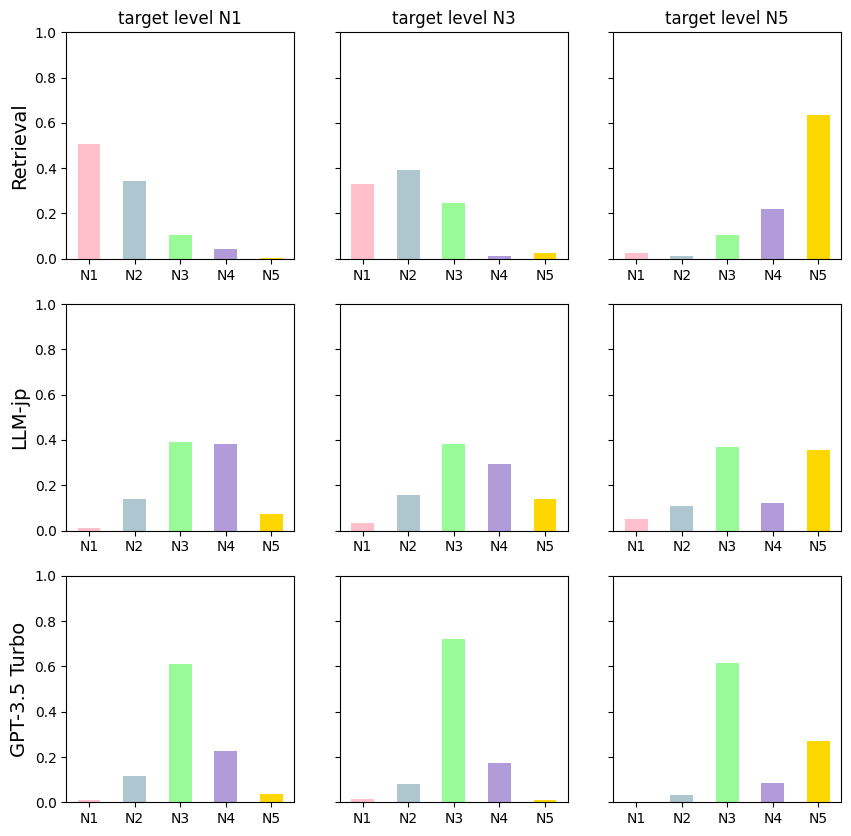

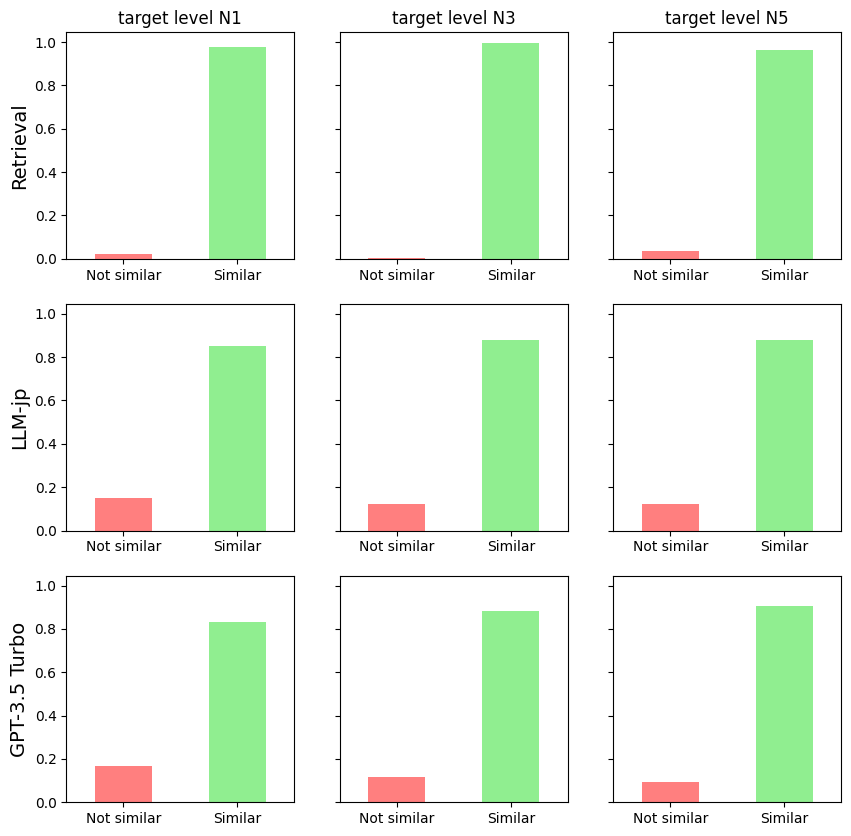

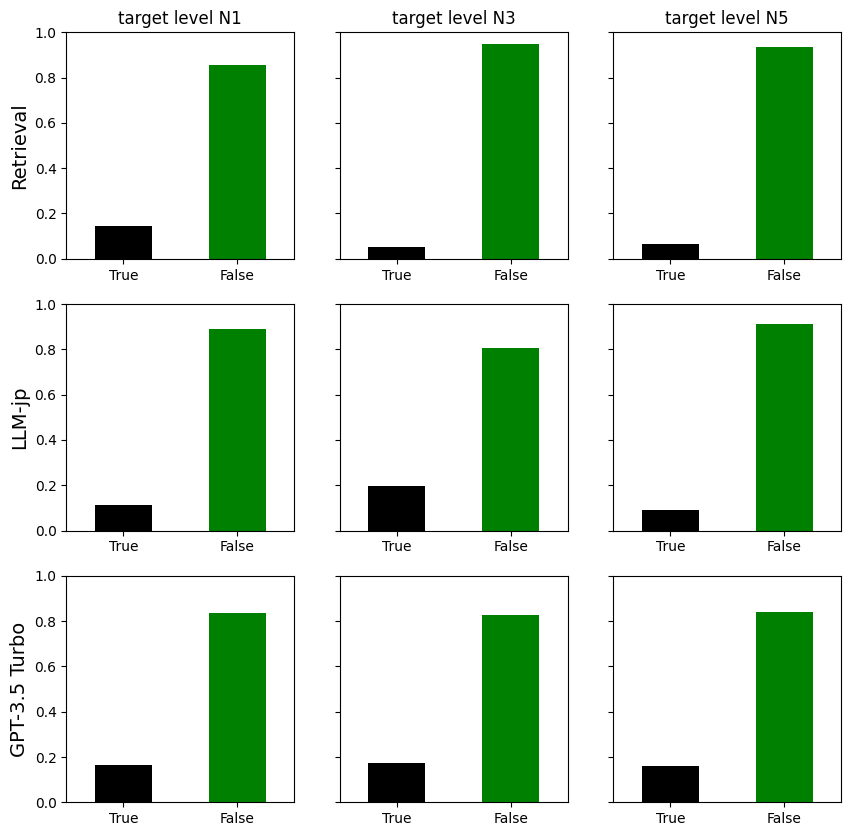

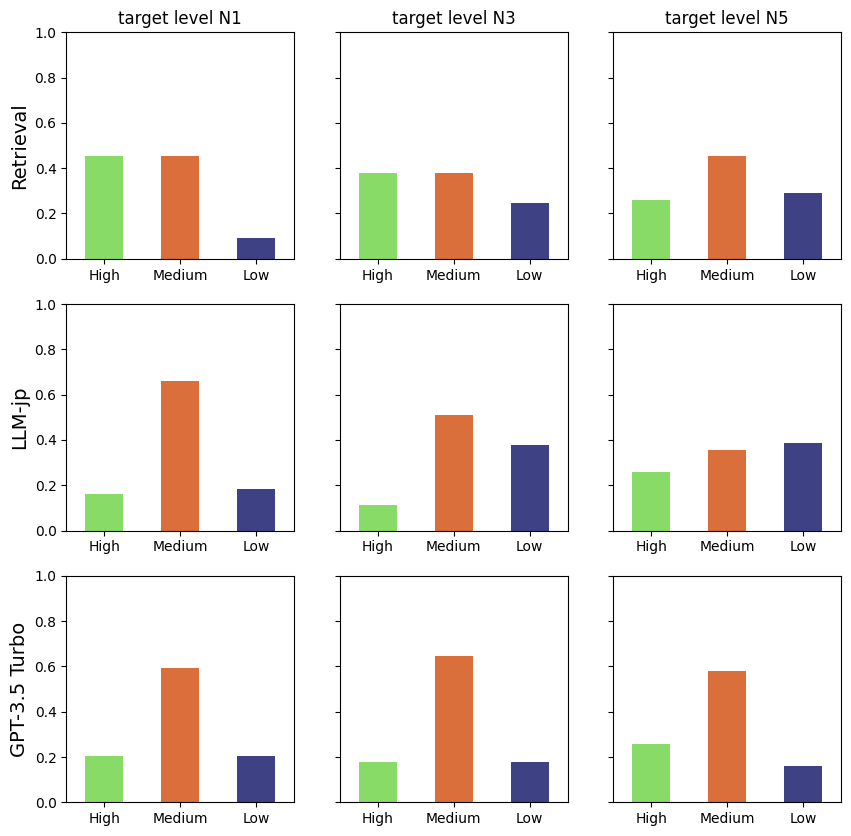

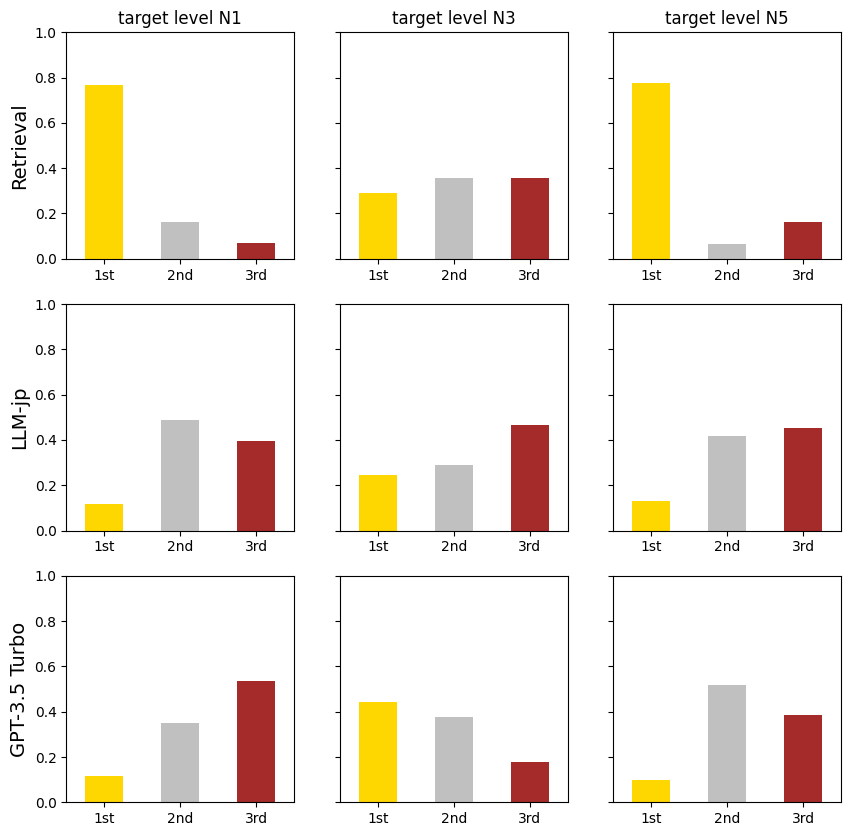

In [153]:
target_annotators = 'human'
starts_bool = True # else expects target_annotators to be list

categories = ['level_human', 'sense_human', 'reject', 'diversity_human', 'rank_human']
colors_by_category = [colors, ["#FF7F7F", 'lightgreen'], ['black', 'green'], ["#89DB67", "#DB6F3C", "#3E4184"], ["gold", "silver", "brown"]]

if starts_bool:
    df_plot = df[df["ann_id"].str.startswith(target_annotators)]
else: 
    df_plot = df[df["ann_id"].isin(target_annotators)]

# fix nans
df_plot['level_human'] = df_plot['level_human'].apply(lambda x: x if x != 'rejected' else np.nan)
df_plot['sense_human'] = df_plot['sense_human'].apply(lambda x: x if x != 'rejected' else np.nan)


for category, color_map in zip(categories, colors_by_category):
    plot_function(df_plot, category, color_map, title=f"{category}_ann_{target_annotators}")

In [144]:
#df_plot = df[df["ann_id"].str.startswith("human")]
#df_plot[df_plot['level_human'] == 'rejected'] = np.nan
#plot_function(df_plot, 'level_human', colors, title="level_human")

#### Sense 

(plots - not really needed but grouping is)

In [145]:
#df_plot = df[df["ann_id"].str.startswith("human")]
#df_plot[df_plot['sense_human'] == 'rejected'] = np.nan
#plot_function(df_plot, target="sense_human", colors=["#FF7F7F", 'lightgreen'], title="sense_human")

#### Reject 

In [146]:
df[df["ann_id"].str.startswith("human_lea")]["reject"].value_counts()

reject
False    533
True      82
Name: count, dtype: int64